**Max Cut Problem**

In [2]:
!pip install networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.9 MB/s eta 0:00:00:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyquil 3.5.0 requires lark<0.12.0,>=0.11.1, which is not installed.
pyquil 3.5.0 requires retry<0.10.0,>=0.9.2, which is not installed.
pyquil 3.5.0 requires scipy<2.0.0,>=1.6.1, which is not installed.
pyquil 3.5.0 requires types-python-dateutil<3.0.0,>=2.8.19, which is not installed.
pyquil 3.5.0 requires types-retry<0.10.0,>=0.9.9, which is not installed.
pyquil 3.5.0 requires networkx<3.0,>=2.5, but you have networkx 3.1 which is incompatible.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

Generating a graph with 4 nodes

In [4]:
n = 4  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
elist = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)

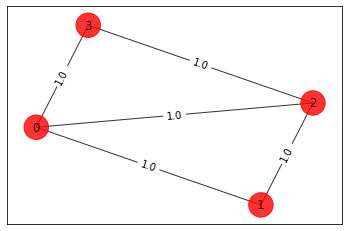

In [5]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    
draw_graph(G, colors, pos)

In [6]:
# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)

[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


**Brute Force Approach**

For n = 4, we will try all the 2^4 combinations.

case = [0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0] cost = 3.0
case = [0, 1, 0, 0] cost = 2.0
case = [1, 1, 0, 0] cost = 3.0
case = [0, 0, 1, 0] cost = 3.0
case = [1, 0, 1, 0] cost = 4.0
case = [0, 1, 1, 0] cost = 3.0
case = [1, 1, 1, 0] cost = 2.0
case = [0, 0, 0, 1] cost = 2.0
case = [1, 0, 0, 1] cost = 3.0
case = [0, 1, 0, 1] cost = 4.0
case = [1, 1, 0, 1] cost = 3.0
case = [0, 0, 1, 1] cost = 3.0
case = [1, 0, 1, 1] cost = 2.0
case = [0, 1, 1, 1] cost = 3.0
case = [1, 1, 1, 1] cost = 0.0

Best solution = [1, 0, 1, 0] cost = 4.0


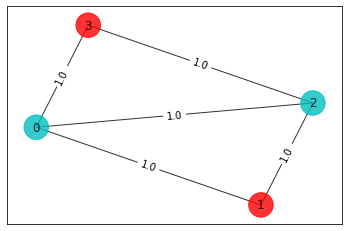

In [8]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print("case = " + str(x) + " cost = " + str(cost))

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))

**Mapping to the Ising Problem**

In [13]:
!pip install -U qiskit-aer
!pip install qiskit-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 2.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 633.5/633.5 kB 9.3 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for docplex: filename=docplex-2.25.236-py3-none-any.whl size=671349 sha256=9150033c107f4a6da68a9f641262d47af23ea6ef39106d37272f74ed1fbc98e7
  Stored in directory: /home/jovyan/.cache/pip/wheels/02/32/20/7f3f85d090da2c3b1ec41de83f17f426a05acc5d9f5e8a1c9f
Successfully built docplex


In [14]:
from qiskit_aer import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [15]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_2*x_3 + 3*x_0 + 2*x_1
  + 3*x_2 + 2*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3



In [16]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -2.5
Ising Hamiltonian:
0.5 * IIZZ
+ 0.5 * IZIZ
+ 0.5 * ZIIZ
+ 0.5 * IZZI
+ 0.5 * ZZII


In [17]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())

objective function value: 4.0
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0
status: SUCCESS


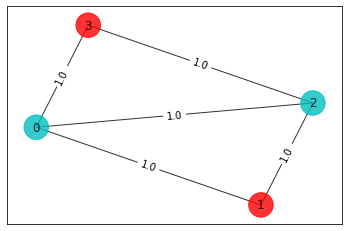

In [20]:
colors = ["r" if result[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

**Using OpenQAOA**

In [1]:
!pip install openqaoa

  Using cached openqaoa-0.1.3-py3-none-any.whl (296 kB)
  Using cached amazon_braket_sdk-1.46.0-py3-none-any.whl (261 kB)
  Using cached qiskit-0.43.2-py3-none-any.whl
  Using cached qiskit_ibm_provider-0.6.1-py3-none-any.whl (233 kB)
  Using cached azure_quantum-0.28.277227-py3-none-any.whl (199 kB)
  Using cached qdk-0.28.277227-py3-none-any.whl (35 kB)
  Using cached qiskit_qir-0.3.1-py2.py3-none-any.whl (19 kB)
  Using cached qiskit_ionq-0.4.1-py3-none-any.whl (37 kB)
  Using cached amazon_braket_schemas-1.18.0-py3-none-any.whl (115 kB)
  Using cached amazon_braket_default_simulator-1.16.0-py3-none-any.whl (206 kB)
  Using cached oqpy-0.1.2-py3-none-any.whl (27 kB)
  Using cached boto3-1.26.164-py3-none-any.whl (135 kB)
  Using cached openpulse-0.5.0-py3-none-any.whl (377 kB)
  Using cached qiskit_ibmq_provider-0.20.2-py3-none-any.whl (241 kB)
  Using cached requests_ntlm-1.1.0-py2.py3-none-any.whl (5.7 kB)
  Using cached azure_core-1.27.1-py3-none-any.whl (174 kB)
  Using cached a

In [2]:
from openqaoa import QAOA

ModuleNotFoundError: No module named 'openqaoa'